In [1]:
#@title 設定圖片
import cv2
from google.colab.patches import cv2_imshow
cv2.imshow = cv2_imshow
import numpy as np
from copy import copy

choose = 'CoP' #@param ['CoP', 'Fish', 'Veg']

image = {
  'CoP':['CoP.jpg','https://encrypted-tbn0.gstatic.com/images?q=tbn:ANd9GcTJ6sLtvjXCKjGxtmkV3FqxWk3O9WwSuvCE1g&usqp=CAU'],
  'Fish':['Fish.jpg','https://d32kak7w9u5ewj.cloudfront.net/media/image/2018/11/2e6888eb9fb4481d936af71854b55f66.jpg'],
  'Veg':['Veg.jpg','https://gdb.voanews.com/DD9EFE8A-F787-4FB1-B0DC-39E627C2DB04_w408_r1_s.jpg']
}
!wget -O {image[choose][0]} {image[choose][1]}
img = cv2.imread(image[choose][0])

--2022-02-13 09:23:30--  https://encrypted-tbn0.gstatic.com/images?q=tbn:ANd9GcTJ6sLtvjXCKjGxtmkV3FqxWk3O9WwSuvCE1g
Resolving encrypted-tbn0.gstatic.com (encrypted-tbn0.gstatic.com)... 74.125.137.113, 74.125.137.102, 74.125.137.100, ...
Connecting to encrypted-tbn0.gstatic.com (encrypted-tbn0.gstatic.com)|74.125.137.113|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 5352 (5.2K) [image/jpeg]
Saving to: ‘CoP.jpg’

CoP.jpg             100%[===================>]   5.23K  --.-KB/s    in 0s      

2022-02-13 09:23:30 (45.7 MB/s) - ‘CoP.jpg’ saved [5352/5352]



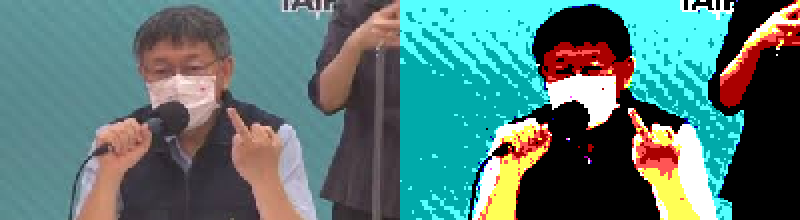

In [2]:
#@title Subsampling & Quantization

裁切圖片 = True #@param {type:"boolean"}
transparanet_color = [192,192,192] #@param 

 # B, G, R,
palette = np.array([
  [0,0,0],
  [170,0,0],
  [0,170,0],
  [170,170,0],
  [0,0,170],
  [170,0,170],
  [0,170,170], #[0,85,170],
  [170,170,170],
  [85,85,85],
  [255,85,85],
  [85,255,85],
  [255,255,85],
  [85,85,255],
  [255,85,255],
  [85,255,255],
  [255,255,255],
])

def C256toC16(img):
  img = copy(img)
  for i in range(img.shape[0]):
    for j in range(img.shape[1]):
      if all(img[i,j,:]==transparanet_color):
        img[i,j,:] = palette[7]
      elif img[i,j,:].mean()>128:
        for k in range(3):
          img[i,j,k] = 255 if img[i,j,k]>127 else 85
      else:
        for k in range(3):
          img[i,j,k] = 170 if img[i,j,k]>127 else 0
  return img

def C16to8086(img):
  img = copy(img)
  img2 = np.zeros(shape=img.shape[:2],dtype=int)
  for i in range(img.shape[0]):
    for j in range(img.shape[1]):
     img2[i,j] = np.where(np.all((palette==img[i,j,:]),axis=1))[0][0]
  return img2

def _8086toC16(img):
  return palette[img]

def show(img_list):
  for i in range(len(img_list)):
    img_list[i] = cv2.resize(img_list[i], (400,220), interpolation=cv2.INTER_NEAREST) if 裁切圖片 else img_list[i]
  for i in range(int(len(img_list)/2)):
    cv2.imshow(np.hstack([img_list[2*i],img_list[2*i+1]]))

img2 = cv2.resize(img, (200,110), interpolation=cv2.INTER_NEAREST) if 裁切圖片 else img
img3 = C256toC16(img2)
img4 = C16to8086(img3)

show([img2,img3])

In [3]:
#@title Run Length Coding (create .asm code)

def ImgToRunLengthCoding(img):
  encode = []
  color_count = 0
  color_tmp = img[0,0]
  for i in range(img.shape[0]):
    for j in range(img.shape[1]):
      if color_tmp == img[i,j] and color_count<15:
        color_count += 1
        # print('+',end='')
      else:
        # print('+',color_tmp)
        encode.append(hex(color_count)[2]+hex(color_tmp)[2])
        color_tmp = img[i,j]
        color_count = 1  
  encode.append(hex(color_count)[2]+hex(color_tmp)[2])
  return encode

def CCITTTo8086code(CCITT,name):
  encode_re = name + ' \\'
  for i,code in enumerate(CCITT):
    if i%10==0:
      encode_re += '\ndb  '
    encode_re += '0' if code>'9' else ' '
    encode_re += code
    encode_re += 'h,' if i%10!=9 else 'h'
  encode_re = encode_re[:-1] # delete last ','
  return encode_re 

def EncodeTo8086(encode,img_sample):
  img = np.array([],dtype=int)
  point = encode.find('\\')
  while True:
    point = encode.find('h',point+1)
    code = encode[point-2:point]
    if point == -1:
      return img.reshape(img_sample.shape)
    for i in range(int(code[0], 16)):
      img = np.append(img, int(code[1], 16))

RunLengthCoding = ImgToRunLengthCoding(img4)
encode = CCITTTo8086code(RunLengthCoding,choose)
img5 = _8086toC16(EncodeTo8086(encode,img4))

encode

'CoP \\\ndb  0fbh,0fbh,0fbh,0fbh,0fbh,0fbh,0fbh,0fbh,0fbh, 5bh\ndb   2fh, 20h, 3fh, 1bh, 20h, 3fh, 30h, 2fh, 20h, 2fh\ndb   60h, 19h,0f0h,0d0h, 14h, 1ch, 1eh,0fbh,0fbh,0fbh\ndb  0fbh,0fbh,0fbh,0fbh,0fbh,0fbh, 5bh, 2fh, 20h, 3fh\ndb  090h, 2fh, 20h, 2fh, 30h, 2fh,0f0h,0e0h, 24h, 2eh\ndb  0fbh,0fbh,0fbh,0fbh,0fbh,0fbh, 2bh, 23h, 21h, 10h\ndb   11h, 23h,0fbh,0fbh,0abh, 2fh, 20h, 2fh,0a0h, 2fh\ndb   20h, 2fh, 30h, 1fh, 1bh,0f0h,0c0h, 14h, 1ch, 3fh\ndb   1eh,0fbh,0fbh,0fbh,0fbh,0fbh,09bh, 23h, 41h,0a0h\ndb   13h,0fbh,0fbh,09bh, 2fh, 20h, 2fh, 20h, 6fh, 20h\ndb   2fh, 20h, 2fh, 30h, 1fh,0f0h,0b0h, 24h, 5fh, 1eh\ndb  0bbh, 23h, 7bh, 43h,0fbh,0fbh,0fbh, 6bh, 13h, 5bh\ndb   13h,0f0h, 70h, 13h,0fbh,0fbh, 5bh, 2fh, 20h, 2fh\ndb   20h, 2fh, 3bh, 1fh, 30h, 1fh, 20h, 2fh, 30h, 2fh\ndb  0f0h, 80h, 14h, 1eh, 4fh, 2eh, 2ch,0bbh, 23h, 7bh\ndb   43h, 8bh, 13h,0abh, 13h,0abh, 13h,0fbh, 5bh, 13h\ndb   4bh,0f0h,0a0h, 11h,0fbh,0fbh, 5bh, 8fh, 11h, 4bh\ndb  0dfh,0f0h, 80h, 6fh, 1eh, 2ch, 14h, 3bh, 33h,0fbh\nd

In [4]:
#@title 複製上面程式碼排版後應變成這樣：
print(encode[:520])
print('...')

CoP \
db  0fbh,0fbh,0fbh,0fbh,0fbh,0fbh,0fbh,0fbh,0fbh, 5bh
db   2fh, 20h, 3fh, 1bh, 20h, 3fh, 30h, 2fh, 20h, 2fh
db   60h, 19h,0f0h,0d0h, 14h, 1ch, 1eh,0fbh,0fbh,0fbh
db  0fbh,0fbh,0fbh,0fbh,0fbh,0fbh, 5bh, 2fh, 20h, 3fh
db  090h, 2fh, 20h, 2fh, 30h, 2fh,0f0h,0e0h, 24h, 2eh
db  0fbh,0fbh,0fbh,0fbh,0fbh,0fbh, 2bh, 23h, 21h, 10h
db   11h, 23h,0fbh,0fbh,0abh, 2fh, 20h, 2fh,0a0h, 2fh
db   20h, 2fh, 30h, 1fh, 1bh,0f0h,0c0h, 14h, 1ch, 3fh
db   1eh,0fbh,0fbh,0fbh,0fbh,0fbh,09bh, 23h, 41h,0a0h
db   13h,0fbh,0fbh,09bh, 2fh
...


In [5]:
#@title 結果(壓縮比)

print('行數節省:',int(img4.shape[0]*img4.shape[1]/10),'->',encode.count('\n'),'line')
print('壓縮比:',(img4.shape[0]*img4.shape[1])/(10*encode.count('\n')))

行數節省: 2200 -> 355 line
壓縮比: 6.197183098591549


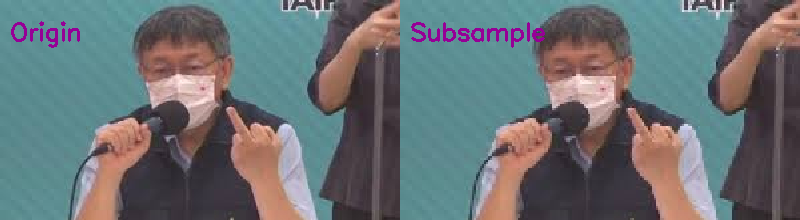

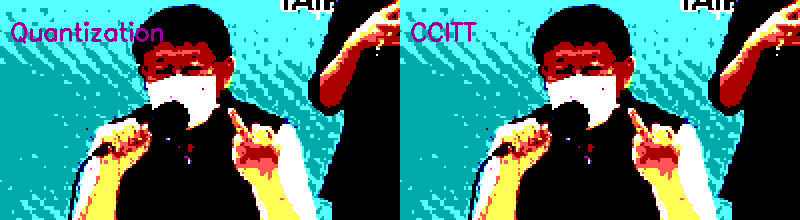

In [6]:
#@title 驗證

def add_label(img,label):
  img2 = cv2.resize(img, (400,220), interpolation=cv2.INTER_NEAREST)
  img2 = cv2.putText(img2, label, (10, 40), cv2.FONT_HERSHEY_SIMPLEX, 0.8, (150,0,150), 2)
  return img2

img_list = [
  add_label(img,'Origin'),
  add_label(img2,'Subsample'),
  add_label(img3,'Quantization'),
  add_label(img5,'CCITT'),  
]

cv2.imshow(np.hstack([img_list[0],img_list[1]]))
cv2.imshow(np.hstack([img_list[2],img_list[3]]))